In [4]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from unet import UNetModel
from rf import RectifiedFlow

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = UNetModel(in_channels=4, out_channels=3)
model.load_state_dict(torch.load('/data/edherron/r2sRL/wandb/run-20240605_102001-i3ropkxm/files/UNetModel_9.pt'))

rf = RectifiedFlow(model, device, num_steps=10)

(640, 480)
image_tensor torch.Size([3, 480, 640])


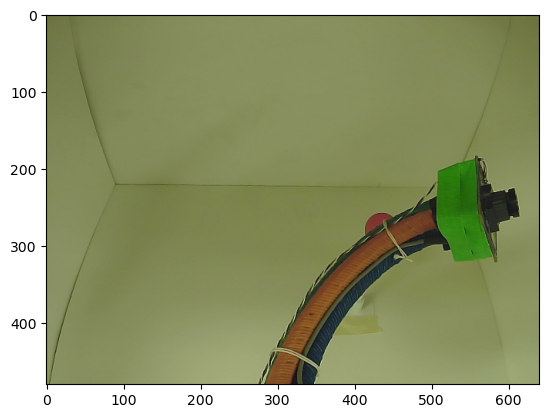

In [17]:
# Load the image
real_img = Image.open('/data/real_to_sim_data/paired_real_sim_images/example/tip_step_1.jpg')
print(real_img.size)

# Convert the image to a tensor and scale to [0, 1]
image_tensor = transforms.ToTensor()(real_img)
print('image_tensor', image_tensor.shape)

plt.imshow(real_img)

torch.Size([3, 120, 160])


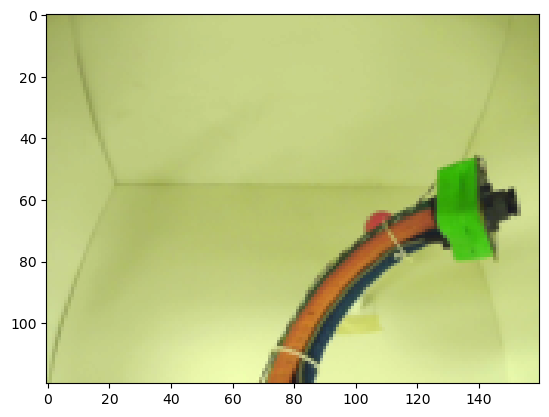

In [18]:
# Define the transform with resizing and conversion to tensor
transform = transforms.Compose([
    transforms.Resize((120, 160)),  # Resize to 160x120
    transforms.ToTensor()           # Convert to tensor and scale to [0, 1]
])

# Apply the transform to the image
image_tensor = transform(real_img)
print(image_tensor.shape)

# Normalize the image to [0, 1]
min_val = torch.min(image_tensor)
max_val = torch.max(image_tensor)
scaled_img_tensor = (image_tensor - min_val) / (max_val - min_val)

plt.imshow(scaled_img_tensor.permute(1, 2, 0))

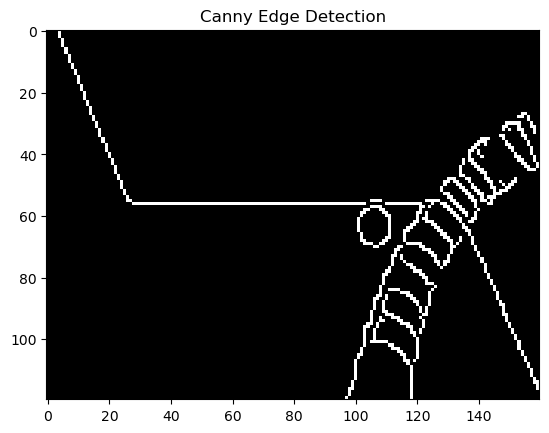

In [31]:
# Convert the tensor to a numpy array
scaled_img_np = scaled_img_tensor.permute(1, 2, 0).numpy()

# Convert the image to uint8
scaled_img_np = (scaled_img_np * 255).astype(np.uint8)

# Convert the image to grayscale for Canny edge detection
gray_img = cv2.cvtColor(scaled_img_np, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detection
edges_real = cv2.Canny(gray_img, 100, 200)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.show()

(640, 480)


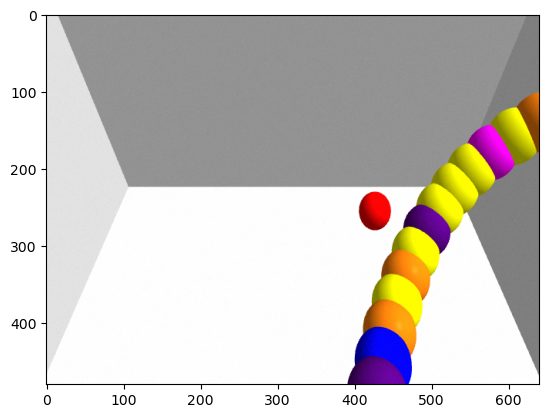

In [20]:
# Load the image
sim_img = Image.open('/data/real_to_sim_data/paired_real_sim_images/example/world_1.png')
print(sim_img.size)


plt.imshow(sim_img)

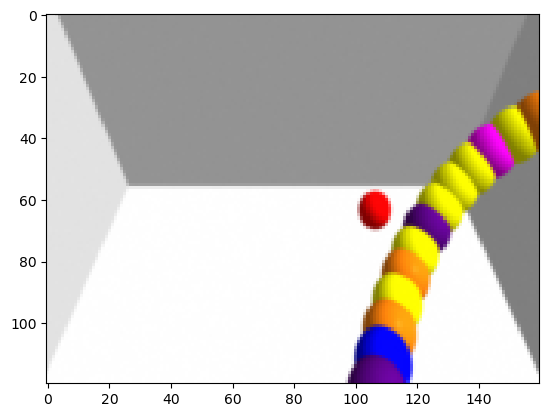

In [21]:
transform_list = [
    transforms.Resize((120, 160)),  # Resizing to a larger size for demonstration purposes
    transforms.ToTensor()
]

transform = transforms.Compose(transform_list)

sim_img_tensor = transform(sim_img)

plt.imshow(sim_img_tensor.permute(1, 2, 0))

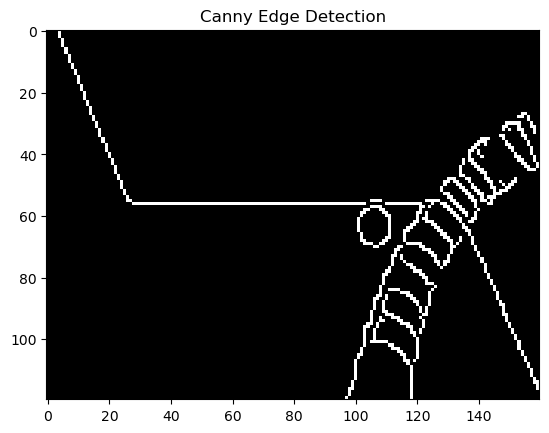

In [22]:
# Convert the tensor to a numpy array
scaled_img_np = sim_img_tensor.permute(1, 2, 0).numpy()

# Convert the image to uint8
scaled_img_np = (scaled_img_np * 255).astype(np.uint8)

# Convert the image to grayscale for Canny edge detection
gray_img = cv2.cvtColor(scaled_img_np, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_img, 100, 200)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.show()

In [32]:
x0 = scaled_img_tensor.unsqueeze(0).to(device)
x1 = sim_img_tensor.unsqueeze(0).to(device)
canny_x0 = torch.tensor(edges_real).unsqueeze(0).unsqueeze(0).to(device).float()

print(x0.shape, x1.shape, canny_x0.shape)

torch.Size([1, 3, 120, 160]) torch.Size([1, 3, 120, 160]) torch.Size([1, 1, 120, 160])


In [33]:
pred_x1 = rf.sample_ode(x0, canny_x0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


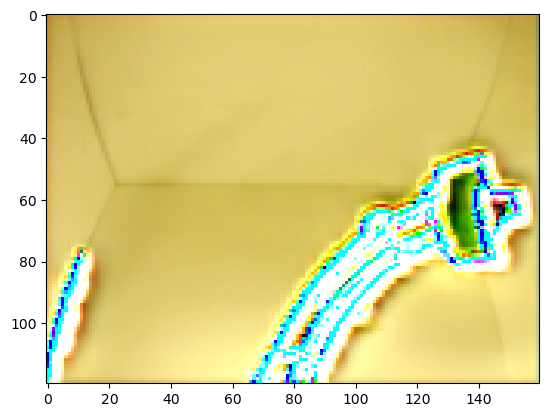

In [34]:
plt.imshow(pred_x1[0].cpu().detach().permute(1, 2, 0))